In [1]:
from google.colab import drive
drive.mount('/content/drive')
%cd "/content/drive/My Drive/Colab Notebooks/normalizing-flows"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive/Colab Notebooks/normalizing-flows


In [0]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.datasets import mnist
from flows import Flow
from flows.affine import Planar, Radial
from flows.sylvester import TriangularSylvester
from models.vae import GatedConvVAE

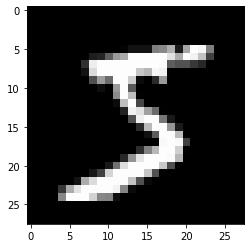

In [3]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()
X_train = X_train / 255
X_test = X_test / 255
plt.imshow(X_train[0], cmap='gray')

In [0]:
n_layers = 4
flow = Flow(TriangularSylvester())
for i in range(1, n_layers):
    flip_z = i % 2 != 0
    flow(TriangularSylvester(flip_z=flip_z))

In [0]:
x_train = np.expand_dims(X_train, axis=-1)
beta_update = lambda i, beta: 1.0E-3 / tf.exp(-i)
vae = GatedConvVAE(x_train.shape[1], x_train.shape[2], flow, z_size=32, beta_update_fn=beta_update)

In [0]:
vae.fit(x_train, x_train, epochs=10, batch_size=128)

Train on 60000 samples
Epoch 1/10
22400/60000 [==========>...................] - ETA: 7:20 - loss: 0.2750

In [0]:
x_test = np.expand_dims(X_test, axis=-1)
x_pred = vae.predict(x_test)

In [0]:
plt.subplot(2,4,1)
plt.imshow(X_test[0], cmap='gray')
plt.subplot(2,4,2)
plt.imshow(X_test[1], cmap='gray')
plt.subplot(2,4,3)
plt.imshow(X_test[2], cmap='gray')
plt.subplot(2,4,4)
plt.imshow(X_test[3], cmap='gray')
plt.subplot(2,4,5)
plt.imshow(x_pred[0].squeeze(), cmap='gray')
plt.subplot(2,4,6)
plt.imshow(x_pred[1].squeeze(), cmap='gray')
plt.subplot(2,4,7)
plt.imshow(x_pred[2].squeeze(), cmap='gray')
plt.subplot(2,4,8)
plt.imshow(x_pred[3].squeeze(), cmap='gray')
plt.show()

In [0]:
z_mu, z_log_sigma, params = vae.encoder.predict(x_test[10:11])
plt.figure(figsize=(4*6,2*4))
for i in range(1,9):
  x_pred = vae.decoder.predict([z_mu, z_log_sigma, params])
  plt.subplot(2,4,i)
  plt.imshow(tf.squeeze(x_pred).numpy())